In [ ]:
pip install torch matplotlib numpy==1.26.4

In [1]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

# EDA

In [2]:
words = open("/Users/outbell/Ajay/DeepLearning/GenAI/Pytorch/names.txt").read().splitlines()
print(words[:10])
random.seed(2147483647)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
print(words[:10], n1, n2)

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
['khole', 'harbour', 'devon', 'baine', 'erisha', 'ivani', 'hollyn', 'kristell', 'zyva', 'ella'] 25626 28829


In [3]:
len(words)

32033

In [4]:
chars = []
for w in words:
    chars += list(w)
chars = sorted(set(chars))
chars

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

# Dataset Preprocessing

In [5]:
#vocab
stoi = {ch : i+1 for i, ch in enumerate(chars)}
itos = {i+1 : ch for i, ch in enumerate(chars)}
stoi['.'] = 0
itos[0] = '.' 

In [6]:
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [7]:
def build_dataset(words, block_size, stoi = stoi, itos = itos):
    X = []
    y = []
    for w in words:
        w += '.'
        context = [0] * block_size
        for ch in w:
            ix = stoi[ch]
            X.append(context)
            y.append(ix)
            context = context[1:] + [ix]
    return torch.tensor(X), torch.tensor(y)
        

block_size = 3
Xtr, ytr = build_dataset(words[:n1], block_size)
Xval, yval = build_dataset(words[n1:n2], block_size)
Xtest, ytest = build_dataset(words[n2:], block_size)

In [8]:
print(Xtr.shape, ytr.shape, Xval.shape, yval.shape, Xtest.shape, ytest.shape)

torch.Size([182546, 3]) torch.Size([182546]) torch.Size([22840, 3]) torch.Size([22840]) torch.Size([22760, 3]) torch.Size([22760])


# Model Building

In [19]:
#Evaluate func
def evaluate(l):
    if l == "train":
        Xd = Xtr
        yd = ytr
    elif l == "val":
        Xd = Xval
        yd = yval
    emb = C[Xd]
    emb = emb.view(-1, emb.shape[1] * emb.shape[-1])
    hpreact = emb @ w1
    hpreact = (hpreact - bnmean_running) / bnstd_running
    hpreact = bngain * hpreact + bnbias
    h =  torch.tanh(hpreact)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, yd)
    return loss.item()

In [10]:
#lr
lre = torch.linspace(-3, 0, (30000))
lr = 10**lre
print(lr) 
print(lr.shape)

tensor([0.0010, 0.0010, 0.0010,  ..., 0.9995, 0.9998, 1.0000])
torch.Size([30000])


In [12]:
#Calculate initial loss
torch.tensor(1/27.0).log()

tensor(-3.2958)

(array([201., 181., 194., 183., 148., 132., 144., 129., 120., 137., 109.,
         85., 112.,  82., 120.,  84.,  94.,  79., 110., 103., 126.,  76.,
        103.,  85.,  93., 123.,  86., 117.,  81.,  87., 102., 102., 114.,
         93.,  95., 126., 110., 114., 102., 122., 150., 121., 132., 172.,
        156., 181., 178., 201., 255., 250.]),
 array([-9.99439359e-01, -9.59458491e-01, -9.19477623e-01, -8.79496754e-01,
        -8.39515886e-01, -7.99535018e-01, -7.59554150e-01, -7.19573282e-01,
        -6.79592414e-01, -6.39611546e-01, -5.99630678e-01, -5.59649810e-01,
        -5.19668941e-01, -4.79688073e-01, -4.39707205e-01, -3.99726337e-01,
        -3.59745469e-01, -3.19764601e-01, -2.79783733e-01, -2.39802865e-01,
        -1.99821997e-01, -1.59841129e-01, -1.19860260e-01, -7.98793924e-02,
        -3.98985243e-02,  8.23438168e-05,  4.00632119e-02,  8.00440800e-02,
         1.20024948e-01,  1.60005816e-01,  1.99986684e-01,  2.39967552e-01,
         2.79948421e-01,  3.19929289e-01,  3.59910

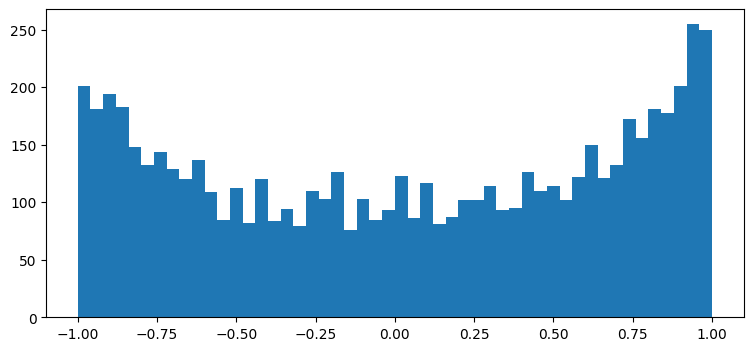

In [187]:
#Check activation distribution
plt.figure(figsize = (9,4))
plt.hist(h.view(-1).tolist(), 50)

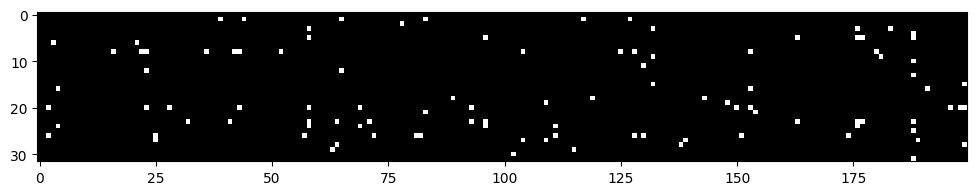

In [178]:
plt.figure(figsize = (12,13))
plt.imshow(h.abs()> 0.99, cmap = "gray", interpolation = "nearest")

In [20]:
#parameters
vocab_size = 27
n_embd = 10
block_size = 3
n_hidden = 200
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator = g)
w1 = torch.randn((block_size * n_embd, n_hidden), generator = g) * (5/3)/(block_size * n_embd)**0.5
#b1 = torch.randn(n_hidden, generator = g) * 0.01
w2 = torch.randn((n_hidden, vocab_size), generator = g) * 0.01
b2 = torch.randn(vocab_size, generator = g) * 0
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.zeros((1, n_hidden))
parameters = [C, w1, w2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True
print("Total Parameters: ", sum([p.nelement() for p in parameters]))

Total Parameters:  12097


In [23]:
#Train
#lr_ls = []
loss_ls = []
step_ls = []

for i in range(100000):
    #Mini batch extract
    ix = torch.randint(0, Xtr.shape[0], (32, ))
    
    #Forward pass
    emb = C[Xtr[ix]]
    emb = emb.view(-1, emb.shape[1] * emb.shape[-1])
    
    #Linear Layer
    hpreact = emb @ w1 #+ b1

    #BatchNorm Layer
    bnmeani = hpreact.mean(0, keepdims = True)
    bnstdi = hpreact.std(0, keepdims = True)
    hpreact = (hpreact - bnmeani) / bnstdi
    hpreact = (bngain * hpreact) + bnbias
    with torch.no_grad():
        bnmean_running = (0.999 * bnmean_running) + (bnmeani * 0.001)
        bnstd_running = (0.999 * bnstd_running) + (bnstdi * 0.001)
        
    #Non-Linear Layer
    h =  torch.tanh(hpreact)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, ytr[ix])
    
    #Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #Weight Update
    for p in parameters:
       p.data += -0.002 * p.grad

    #Track stats
    loss_ls.append(loss.item())
    step_ls.append(i)
    #lr_ls.append(lre[i].item())
    
    if i%10000 == 0:
        train_loss = evaluate("train")
        print(train_loss)

2.1396102905273438
2.123446226119995
2.1221020221710205
2.121006727218628
2.119971752166748
2.1191835403442383
2.1185214519500732
2.118185520172119
2.117278814315796
2.116084575653076


In [24]:
val_loss = evaluate("val")
val_loss

2.1568384170532227

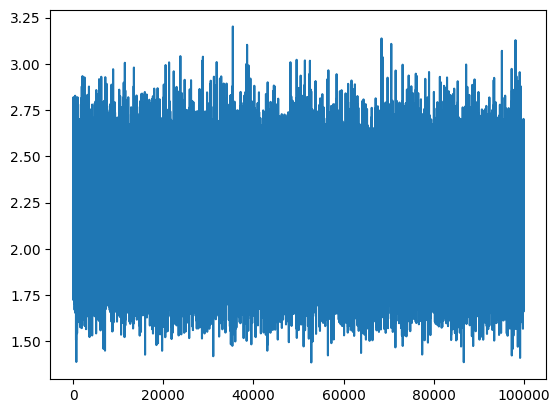

In [111]:
plt.plot(step_ls, loss_ls)

In [108]:
#inference
g = torch.Generator().manual_seed(2147483647)
names = []
def forward(X, name):
    emb = C[X]
    emb = emb.view(1, emb.shape[0]*emb.shape[1])
    hpreact = emb @ w1
    hpreact = (hpreact - bnmean_running) / bnstd_running
    hpreact = bngain * hpreact + bnbias
    h =  torch.tanh(hpreact)
    logits = h @ w2 + b2
    softmax = F.softmax(logits, dim = -1)
    ix = torch.multinomial(softmax, num_samples = 1, generator = g)
    predicted = itos[ix.item()]
    name += predicted
    if predicted == '.':
        names.append(name)
        return
    X = torch.cat((X[1:], ix.view(1)))
    forward(X, name)

for i in range(20):
    X = torch.tensor([0,0,0])
    forward(X, "")

In [109]:
names

['junide.',
 'jakarie.',
 'pres.',
 'amaina.',
 'kai.',
 'ritolett.',
 'juet.',
 'kalinaa.',
 'zamilena.',
 'jedeyainrwie.',
 'lesson.',
 'evy.',
 'arte.',
 'farmunthya.',
 'demmernon.',
 'sumah.',
 'jaylie.',
 'raaya.',
 'jocely.',
 'jamiyandimoun.']